In [8]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score



In [9]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [10]:
data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])

In [11]:
data_base.columns

Index(['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'roe',
       'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'target_12m_final',
       'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit',
       'signed_log_marketcap', 'signed_log_equity', 'ebit_margin',
       'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps', 'ret_12m_vol',
       'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma',
       'cap_category', 'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap',
       'cap_Small Cap'],
      dtype='object')

## Normalizar 

In [12]:
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────
# 0. Asegurar que la columna fecha es datetime
# ─────────────────────────────────────────────
data_base['date'] = pd.to_datetime(data_base['date'])

# ─────────────────────────────────────────────
# 1. Listas de columnas
# ─────────────────────────────────────────────
macro_cols   = ['risk_free_rate']     # mismas para todas las empresas ese día
target_col   = ['target_12m_final','target_class']
meta_cols    = ['date', 'ticker']
feature_cols = [c for c in data_base.columns
                if c not in (macro_cols + meta_cols + [target_col])]

# ─────────────────────────────────────────────
# 2. Conversión explícita a numérico
# ─────────────────────────────────────────────
for col in feature_cols + macro_cols:
    data_base[col] = pd.to_numeric(data_base[col], errors='coerce')

# ─────────────────────────────────────────────
# 3. Función de z-score segura
# ─────────────────────────────────────────────
def safe_zscore(series: pd.Series) -> pd.Series:
    std  = series.std(ddof=0)
    if std == 0 or np.isnan(std):
        # columna plana dentro de la fecha → devolver ceros
        return pd.Series(0, index=series.index)
    return (series - series.mean()) / std

# ─────────────────────────────────────────────
# 4. Normalización cross-seccional por fecha
# ─────────────────────────────────────────────
df_norm = data_base.copy()

df_norm[feature_cols] = (
    df_norm
      .groupby('date')[feature_cols]
      .transform(safe_zscore)
)

# ─────────────────────────────────────────────
# 5. (Opcional) tratar macro_cols en el tiempo
# ─────────────────────────────────────────────
# for col in macro_cols:
#     df_norm[col] = (df_norm[col] - df_norm[col].mean()) / df_norm[col].std(ddof=0)

# ─────────────────────────────────────────────
# 6. Limpieza final (inf y NaN)
# ─────────────────────────────────────────────
#df_norm.replace([np.inf, -np.inf], 0, inplace=True)
#df_norm.fillna(0, inplace=True)

# ─────────────────────────────────────────────
# 7. Guardar
# ─────────────────────────────────────────────
df_norm.to_csv('../data/data_normalized.csv', index=False)

print('Normalización terminada. NaNs totales:',
      df_norm.isna().sum().sum())


Normalización terminada. NaNs totales: 0


In [13]:
df_norm.head()

,ticker,date,vol_1y,max_1y,min_1y,sma_1y,sma_2y,volatility_1y,revenue,eps,ebitda,netinc,roe,evebitda,fcfps,pb,pe,marketcap,ebit,capex,ncfo,equity,de,revenue_yoy,ebitda_yoy,ebit_yoy,eps_yoy,equity_yoy,capex_yoy,pe_yoy,pb_yoy,fcfps_yoy,ncfo_yoy,closeadj,ret_6m,ret_12m,risk_free_rate,target_12m_final,signed_log_revenue,signed_log_ebitda,signed_log_ebit,signed_log_marketcap,signed_log_equity,ebit_margin,net_margin,capex_to_revenue,fcf_yield,ps,ret_12m_vol,ret_6m_vol,sma_diff,dist_max_1y,dist_min_1y,vol_over_sma,cap_category,cap_Large Cap,cap_Mega Cap,cap_Mid Cap,cap_Small Cap
0,A,2001-03-31,-0.051189,-0.006616,-0.082498,-0.044735,-0.026235,1.895254,-0.033126,-0.047603,-0.123944,-0.056301,-0.093314,-0.055641,-0.196229,-0.002207,0.097085,0.134333,-0.135225,0.033614,-0.163258,-0.003776,-0.340135,0.075347,0.053628,0.058104,-0.048302,0.231161,0.380300,-0.123460,-0.480880,-0.003793,0.115306,-0.147471,-1.196618,-1.733620,0.049106,0.112974,0.559165,0.209958,0.240104,0.907186,0.247489,-0.431910,-0.235210,0.113985,-0.187575,-0.125262,-1.177566,-0.935842,-0.288716,-2.187728,-1.162111,-0.114703,0,2.630710,-0.257370,-0.633787,-1.051421
1,A,2002-03-31,-0.082249,-0.153183,-0.195649,-0.168946,-0.071805,0.771516,-0.173545,-0.037678,-0.169029,-0.053727,-0.049513,-0.009248,-0.529466,-0.147762,0.277367,-0.165522,-0.200315,0.137384,-0.416561,-0.036259,-0.354531,-0.262812,0.029319,0.033719,0.108334,-0.165980,-0.150329,0.061135,0.143359,0.067838,0.053988,-0.118389,1.813249,0.093120,0.054019,-1.421420,0.313460,0.266860,0.273196,0.334186,0.249217,-0.058187,0.021181,0.068578,-0.481469,-0.348543,-0.220649,1.265740,-0.155687,0.166119,1.151394,-0.021477,0,-0.348351,-0.252915,1.366681,-0.966493
2,A,2003-03-31,-0.083338,-0.120016,-0.268869,-0.220010,-0.188117,0.770879,-0.275346,-0.403067,-0.404321,-0.256468,-0.303902,-0.531515,-0.601085,-0.107414,-0.177620,-0.243240,-0.453967,0.272615,-0.561828,-0.136254,-0.286480,-1.267981,-0.462329,-1.595626,-0.585515,-0.122308,-0.257094,-0.162344,-0.011551,-0.013948,0.592114,-0.262743,-0.232586,-1.529541,0.038019,1.628988,0.046014,-3.012327,-2.370556,0.115611,0.205588,-0.238651,-0.114305,0.153316,-0.873241,-0.293000,-1.053931,-0.213746,-0.118119,-1.699827,-0.270140,-0.020777,0,-0.329617,-0.193247,-0.601995,0.816497
3,A,2004-03-31,-0.090108,-0.138291,-0.261506,-0.201455,-0.211886,0.601339,-0.285919,-1.376356,-0.670978,-1.424384,-1.100285,-0.640789,-0.297353,0.110629,-0.180373,-0.181469,-0.779212,0.320080,-0.487941,-0.343791,-0.350351,-0.434435,-0.123541,-0.063396,0.148668,-0.794540,-0.042997,0.032726,1.454919,-0.098098,-0.312938,-0.163973,1.292859,1.617257,0.038401,-1.409023,-0.003287,-4.412514,-3.089581,0.282827,0.067075,-0.729570,-1.078149,0.287823,-0.440697,-0.121224,1.758279,0.808255,0.030464,-0.884320,1.485121,-0.045044,0,-0.358703,-0.234206,1.327566,-0.945484
4,A,2005-03-31,-0.087609,-0.215792,-0.252330,-0.245017,-0.224263,1.060502,-0.259091,-0.277902,-0.366724,-0.287258,-0.016165,0.035978,-0.118898,-0.055166,0.146910,-0.268197,-0.362747,0.393201,-0.215127,-0.301684,-0.217195,0.232034,-0.696365,-0.575547,-0.346602,0.058239,-0.237734,-1.107086,-0.259869,-0.083588,-0.684556,-0.270478,-0.395205,-1.364419,0.044928,1.681780,0.055125,0.084594,0.165032,0.015149,0.066688,-0.492634,-0.250246,0.392448,-0.015061,-0.380317,-1.333741,-0.531509,-0.452828,-1.667714,-0.615814,-0.005838,0,-0.379690,-0.243561,1.214598,-0.840526


In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Asegurar tipo datetime
data_base['date'] = pd.to_datetime(data_base['date'])

# Definir features válidas (excluye target y columnas no predictivas)
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'target_12m_final', 'target_class', 'cap_category']
    and not col.startswith('target')
]

# Filtrado de datos válidos
X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_class']
ret_future = data_base['target_12m_final']
mask = X.notnull().all(axis=1) & y.notnull() & ret_future.notnull()

X = X.loc[mask]
y = y.loc[mask]
ret_future = ret_future.loc[mask]
df_filtered = data_base.loc[mask].copy()
X_values = X.values  # ya normalizado por fecha

# Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

# Loop por folds temporales
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_values)):
    X_train, X_test = X_values[train_idx], X_values[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    ret_test = ret_future.iloc[test_idx]
    df_test = df_filtered.iloc[test_idx].copy()

    # Modelo: LogisticRegression multinomial
    clf = LogisticRegression(max_iter=2000, solver='saga')  # ✅ sin multi_class (por defecto multinomial)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Anexar predicciones
    df_test['y_pred'] = y_pred
    df_test['true_class'] = y_test.values
    df_test['ret_12m'] = ret_test.values

    # Evaluación año a año (por test set anual)
    for year, group in df_test.groupby(df_test['date'].dt.year):
        y_true_year = group['true_class']
        y_pred_year = group['y_pred']

        # Métricas de clasificación para ese año
        report = classification_report(y_true_year, y_pred_year, output_dict=True, zero_division=0)

        # Portafolio: acciones predichas como clase 4 (top quintil)
        selected = group[group['y_pred'] == 4]
        portfolio_return = selected['ret_12m'].mean() if not selected.empty else 0.0
        n_stocks = len(selected)

        result_list.append({
            'year': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks,
            'f1_top': report['4']['f1-score'],
            'precision_top': report['4']['precision'],
            'recall_top': report['4']['recall']
        })

# Resultados agregados por año
results = pd.DataFrame(result_list)
annual = results.groupby('year').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean',
    'f1_top': 'mean',
    'precision_top': 'mean',
    'recall_top': 'mean'
}).reset_index()

# Retorno acumulado
annual['cumulative_return'] = (1 + annual['portfolio_return']).cumprod()

# Mostrar resumen
print(annual)

# Gráfico de retorno acumulado
plt.figure(figsize=(10, 5))
plt.plot(annual['year'], annual['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Predicted class == 4)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'target_class'

RIDGE train hasta 2004, test 2004-2024, sin eliminar variables

c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.67907e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.94699e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.86264e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.81784e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users

    year  portfolio_return  n_stocks       mse  cumulative_return
0   2004          0.109739       125  0.087306           1.109739
1   2005          0.246596       125  0.097888           1.383396
2   2006          0.121580       125  0.078837           1.551589
3   2007         -0.123118       125  0.131115           1.360561
4   2008         -0.401312       125  0.325726           0.814551
5   2009          1.172621       125  1.215301           1.769711
6   2010          0.158428       125  0.099391           2.050082
7   2011         -0.020550       125  0.069098           2.007953
8   2012          0.177609       125  0.076597           2.364583
9   2013          0.306628       125  0.093383           3.089631
10  2014          0.146310       125  0.070458           3.541675
11  2015         -0.078350       126  0.067001           3.264183
12  2016          0.252769       126  0.073327           4.089266
13  2017          0.084183       126  0.069294           4.433514
14  2018  

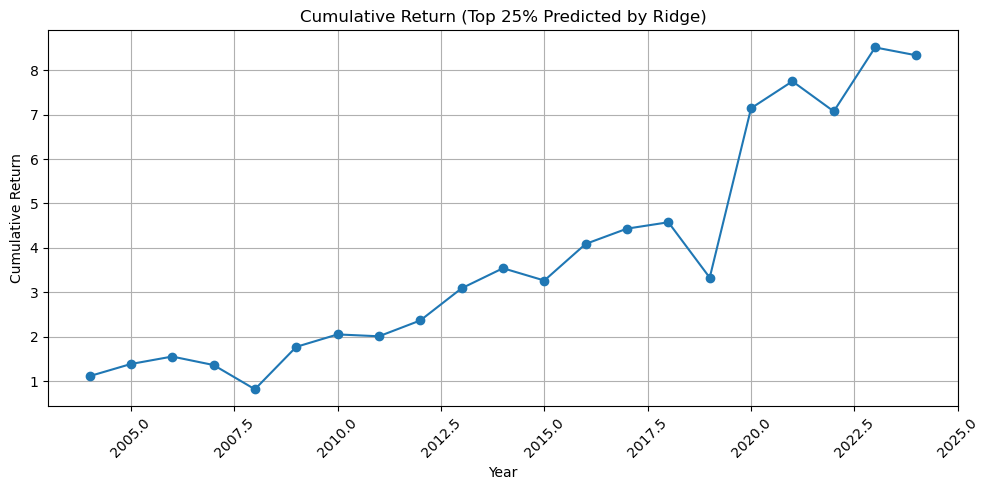

In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Asegurar tipo fecha
data_base['date'] = pd.to_datetime(data_base['date'])

# Definir features
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'target_12m_final', 'target_class', 'cap_category']
    and not col.startswith('target')
]

# Filtrado de datos válidos
X_all = data_base[features].replace([np.inf, -np.inf], np.nan)
y_all = data_base['target_12m_final']
mask = X_all.notnull().all(axis=1) & y_all.notnull()

X_all = X_all[mask]
y_all = y_all[mask]
df_clean = data_base[mask].copy()

# Entrenamiento + evaluación año a año
years = sorted(df_clean['date'].dt.year.unique())
results = []

for i, test_year in enumerate(years):
    if test_year < 2004:
        continue  # Entrenamiento inicial: 1999–2003

    train_years = [y for y in years if y < test_year]
    train_df = df_clean[df_clean['date'].dt.year.isin(train_years)]
    test_df  = df_clean[df_clean['date'].dt.year == test_year]

    X_train = train_df[features]
    y_train = train_df['target_12m_final']
    X_test  = test_df[features]
    y_test  = test_df['target_12m_final']

    # Entrenar Ridge con validación interna de alpha
    model = RidgeCV(alphas=np.logspace(-6, 6, 13), scoring='neg_mean_squared_error', cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    test_df = test_df.copy()
    test_df['y_pred'] = y_pred
    test_df['y_true'] = y_test.values

    # Selección: top 25% predicho
    cutoff = test_df['y_pred'].quantile(0.75)
    top_df = test_df[test_df['y_pred'] > cutoff]
    portfolio_return = top_df['y_true'].mean() if not top_df.empty else 0.0
    n_stocks = len(top_df)

    results.append({
        'year': test_year,
        'portfolio_return': portfolio_return,
        'n_stocks': n_stocks,
        'mse': mean_squared_error(y_test, y_pred)
    })

# Convertir a DataFrame final
results_df = pd.DataFrame(results)
results_df['cumulative_return'] = (1 + results_df['portfolio_return']).cumprod()

# Mostrar resumen
print(results_df)

# Gráfico
plt.figure(figsize=(10,5))
plt.plot(results_df['year'], results_df['cumulative_return'], marker='o')
plt.title("Cumulative Return (Top 25% Predicted by Ridge)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


eliminar variables correlacionadas

In [16]:
# 1. Seleccionar solo features numéricas (ya filtradas en tu lista original)
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'target_12m_final', 'target_class', 'cap_category']
    and not col.startswith('target')
]

# 2. Matriz de correlación
X_all = data_base[features].replace([np.inf, -np.inf], np.nan).dropna()
corr_matrix = X_all.corr().abs()

# 3. Identificar pares altamente correlacionados
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

print(f"Variables eliminadas por alta correlación (> 0.95): {to_drop}")

# 4. Nueva lista de features depurada
features_filtered = [f for f in features if f not in to_drop]


Variables eliminadas por alta correlación (> 0.95): ['sma_1y', 'sma_2y', 'ebit', 'closeadj', 'net_margin']


RIDGE train hasta 2004, test 2004-2024, con eliminación de variables

c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.72986e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.00529e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.92201e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.8861e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\

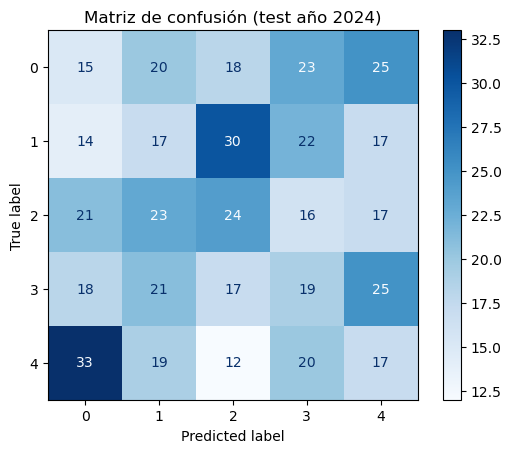

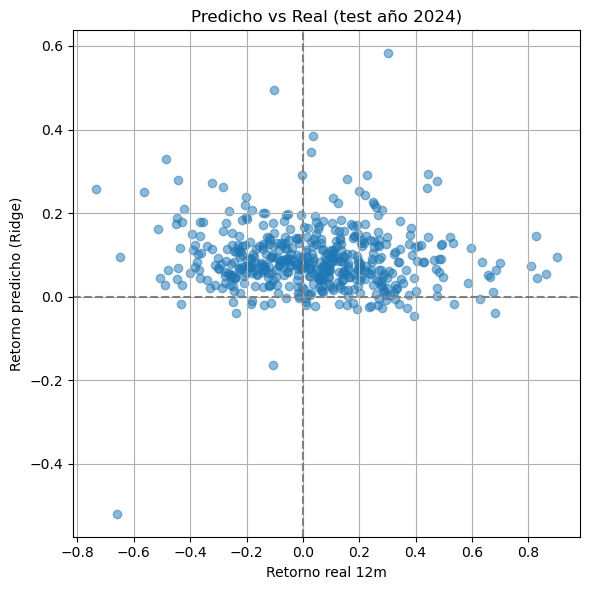

    year  portfolio_return  n_stocks       mse  cumulative_return
0   2004          0.102906       125  0.087648           1.102906
1   2005          0.255395       125  0.096928           1.384583
2   2006          0.132814       125  0.061280           1.568475
3   2007         -0.121881       125  0.133322           1.377307
4   2008         -0.395899       125  0.319381           0.832033
5   2009          1.171515       125  1.213507           1.806772
6   2010          0.161450       125  0.091140           2.098475
7   2011         -0.021322       125  0.067488           2.053730
8   2012          0.183803       125  0.076183           2.431212
9   2013          0.312211       125  0.093559           3.190263
10  2014          0.152699       125  0.069649           3.677413
11  2015         -0.078350       126  0.067058           3.389286
12  2016          0.247775       126  0.073414           4.229067
13  2017          0.085346       126  0.069224           4.589999
14  2018  

In [17]:
# Entrenamiento año a año con Ridge
years = sorted(data_base['date'].dt.year.unique())
results = []

for test_year in years:
    if test_year < 2004:
        continue

    train_years = [y for y in years if y < test_year]
    train_df = data_base[data_base['date'].dt.year.isin(train_years)]
    test_df  = data_base[data_base['date'].dt.year == test_year]

    X_train = train_df[features_filtered].replace([np.inf, -np.inf], np.nan)
    y_train = train_df['target_12m_final']
    X_test  = test_df[features_filtered].replace([np.inf, -np.inf], np.nan)
    y_test  = test_df['target_12m_final']

    mask_train = X_train.notnull().all(axis=1) & y_train.notnull()
    mask_test  = X_test.notnull().all(axis=1) & y_test.notnull()

    X_train = X_train[mask_train]
    y_train = y_train[mask_train]
    X_test  = X_test[mask_test]
    y_test  = y_test[mask_test]
    test_clean = test_df[mask_test].copy()

    # Entrenar modelo
    model = RidgeCV(alphas=np.logspace(-6, 6, 13), scoring='neg_mean_squared_error', cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    # 1. Convertir a clases (quintiles)
    test_clean['y_true'] = y_test.values
    test_clean['y_pred'] = y_pred

    # Convertir a quintiles (5 clases: 0–4)
    y_true_class = pd.qcut(test_clean['y_true'], q=5, labels=False)
    y_pred_class = pd.qcut(test_clean['y_pred'], q=5, labels=False)

    # 2. Matriz de confusión (por último año)
    if test_year == years[-1]:  # solo mostramos para 2024, por ejemplo
        cm = confusion_matrix(y_true_class, y_pred_class, labels=[0,1,2,3,4])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
        disp.plot(cmap="Blues")
        plt.title(f"Matriz de confusión (test año {test_year})")
        plt.show()

        # 3. Dispersión
        plt.figure(figsize=(6,6))
        plt.scatter(test_clean['y_true'], test_clean['y_pred'], alpha=0.5)
        plt.xlabel("Retorno real 12m")
        plt.ylabel("Retorno predicho (Ridge)")
        plt.title(f"Predicho vs Real (test año {test_year})")
        plt.grid(True)
        plt.axhline(0, linestyle='--', color='gray')
        plt.axvline(0, linestyle='--', color='gray')
        plt.tight_layout()
        plt.show()


    # Portafolio: top 25% predicho
    test_clean['y_pred'] = y_pred
    cutoff = test_clean['y_pred'].quantile(0.75)
    top_df = test_clean[test_clean['y_pred'] > cutoff]
    port_ret = top_df['target_12m_final'].mean() if not top_df.empty else 0.0

    results.append({
        'year': test_year,
        'portfolio_return': port_ret,
        'n_stocks': len(top_df),
        'mse': mean_squared_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df['cumulative_return'] = (1 + results_df['portfolio_return']).cumprod()
print(results_df)


# RETORNOS DEL SP500

    year  average_return  cumulative_return
0   2004        0.106057           1.106057
1   2005        0.179495           1.304588
2   2006        0.116882           1.457071
3   2007       -0.080505           1.339770
4   2008       -0.388679           0.819029
5   2009        0.778434           1.456590
6   2010        0.198803           1.746163
7   2011        0.045470           1.825561
8   2012        0.165679           2.128019
9   2013        0.244976           2.649333
10  2014        0.132001           2.999048
11  2015       -0.012338           2.962047
12  2016        0.166030           3.453835
13  2017        0.115157           3.851566
14  2018        0.069384           4.118803
15  2019       -0.163824           3.444045
16  2020        0.721008           5.927231
17  2021        0.133095           6.716118
18  2022       -0.067576           6.262270
19  2023        0.199522           7.511733
20  2024        0.038059           7.797618


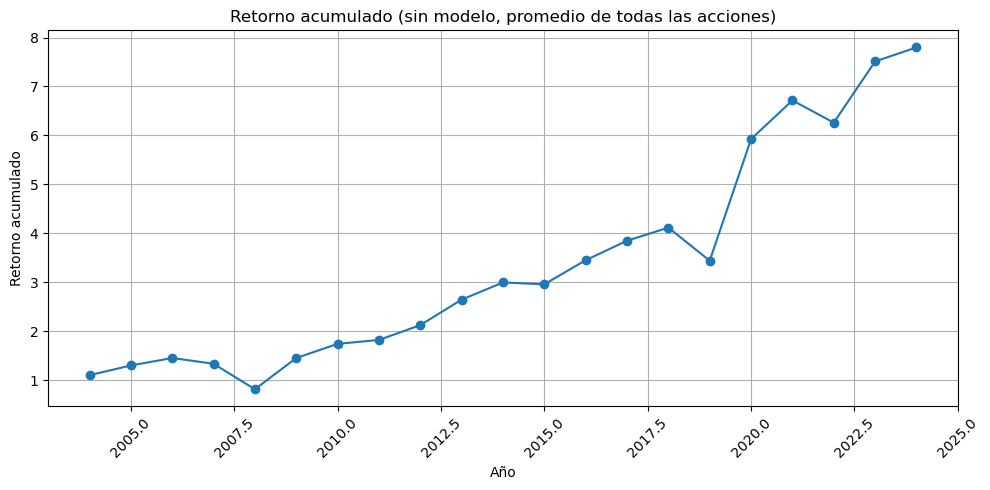

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarse de tener columna de año
data_base['year'] = data_base['date'].dt.year

# Filtrar datos válidos y años desde 2004
df_valid = data_base[data_base['year'] >= 2004][['year', 'target_12m_final']].dropna()

# Calcular el retorno promedio anual (across all stocks)
annual_returns = (
    df_valid.groupby('year')['target_12m_final']
    .mean()
    .reset_index()
    .rename(columns={'target_12m_final': 'average_return'})
)

# Calcular retorno acumulado
annual_returns['cumulative_return'] = (1 + annual_returns['average_return']).cumprod()

# Mostrar tabla
print(annual_returns)

# Graficar
plt.figure(figsize=(10,5))
plt.plot(annual_returns['year'], annual_returns['cumulative_return'], marker='o')
plt.title("Retorno acumulado (sin modelo, promedio de todas las acciones)")
plt.xlabel("Año")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Simple Regression Model


In [6]:
data_base.columns

Index(['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'roe',
       'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'target_12m_final',
       'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit',
       'signed_log_marketcap', 'signed_log_equity', 'ebit_margin',
       'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps', 'ret_12m_vol',
       'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma',
       'cap_category', 'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap',
       'cap_Small Cap', 'target_class'],
      dtype='object')

Simplicidad: Es la referencia más básica y fácil de interpretar. Además este modelo de Regresión lineal sirve como baseline para comparar modelos más complejos (XGBoost, Random Forest,etc). Sus coeficientes muestran la relación entre cada variable y el target (positivo/negativo y fuerza). Es rápido y robusto ya que permite detectar si hay problemas graves (multicolinealidad, outliers, etc.) antes de probar modelos más avanzados. Por últimos, la regresión lineal tiene un riesgo de sobreajuste bajo

Base model con RIDGE

         date  portfolio_return  n_stocks  cumulative_return
0  1999-03-31         -0.057328      40.8           0.942672
1  2000-03-31          0.230826      41.2           1.160265
2  2001-03-31          0.302514      40.6           1.511262
3  2002-03-31          0.104669      40.8           1.669444
4  2003-03-31          0.166061      41.0           1.946673
5  2004-03-31          0.174430      40.8           2.286232
6  2005-03-31         -0.101551      40.8           2.054064
7  2006-03-31          0.143547      40.4           2.348919
8  2007-03-31         -0.082573      41.0           2.154961
9  2008-03-31          0.013118      41.0           2.183229
10 2009-03-31          0.292725      42.0           2.822315
11 2010-03-31          0.096038      41.6           3.093364
12 2011-03-31          0.091360      42.0           3.375974
13 2012-03-31          0.190669      41.6           4.019666
14 2013-03-31          0.089815      41.6           4.380692
15 2014-03-31          0

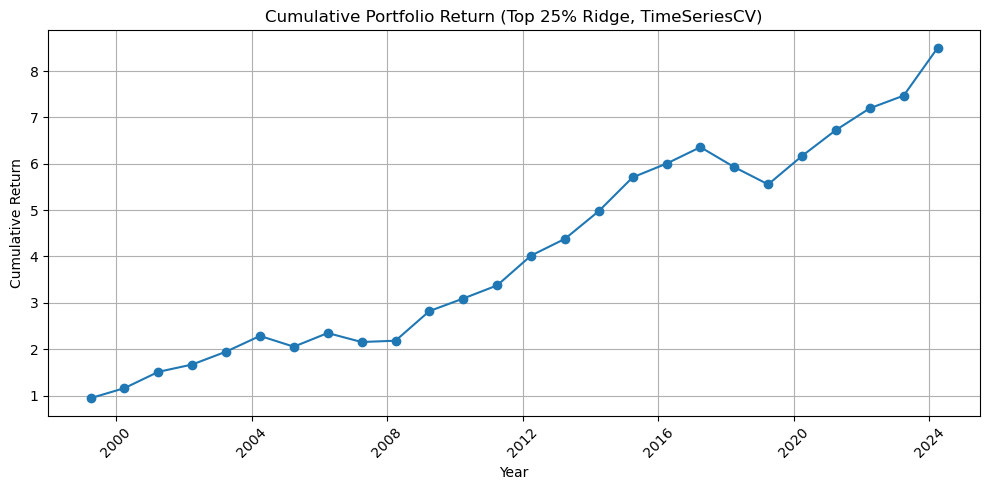

In [15]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Fijar semillas
np.random.seed(42)

# 1. Ordenar por fecha
normalized = df_norm.copy()

# 2. Definir features (evitando normalizar de nuevo)
features = [
    col for col in normalized.columns
    if col not in ['ticker', 'date', 'cap_category', 'target_12m_final', 'target_class']
    and not col.startswith('target')
]

X = normalized[features].replace([np.inf, -np.inf], np.nan)
y = normalized['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = normalized.loc[mask].copy()

# 3. NO re-normalizamos porque ya está normalizado
X_scaled = X.values  # ya normalizado

# 4. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

# 5. Cross-validation manual fold-by-fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 6. Ridge Regression con validación interna de alpha
    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), scoring='neg_mean_squared_error', cv=5)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    # 7. DataFrame solo test
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final']].copy()
    df_test['predicted_return'] = y_pred
    df_test['fold'] = fold + 1

    # 8. Portafolio: selecciona top N activos predichos
    for year, group in df_test.groupby('date'):
        overperf = group[group['predicted_return'] > group['predicted_return'].quantile(0.5)]  # Top 25%
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 9. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 10. Métrica ANUAL: promedio sobre los folds
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 11. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 12. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Top 25% Ridge, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


    date  portfolio_return  n_stocks  precision    recall  f1_score  \
0   1999          0.177064      20.8   0.231169  0.231169  0.231169   
1   2000          0.198094      20.6   0.337417  0.337417  0.337417   
2   2001          0.215347      20.6   0.431738  0.431738  0.431738   
3   2002         -0.317286      19.2   0.157477  0.157477  0.157477   
4   2003          0.777507      20.6   0.450886  0.450886  0.450886   
5   2004          0.185279      19.6   0.352782  0.352782  0.352782   
6   2005          0.182752      20.6   0.281732  0.281732  0.281732   
7   2006          0.161458      20.6   0.332121  0.332121  0.332121   
8   2007         -0.145105      20.0   0.170150  0.170150  0.170150   
9   2008         -0.451598      20.8   0.241688  0.241688  0.241688   
10  2009          1.521252      21.4   0.637662  0.637662  0.637662   
11  2010          0.205593      21.0   0.255108  0.255108  0.255108   
12  2011          0.006126      21.2   0.227273  0.227273  0.227273   
13  20

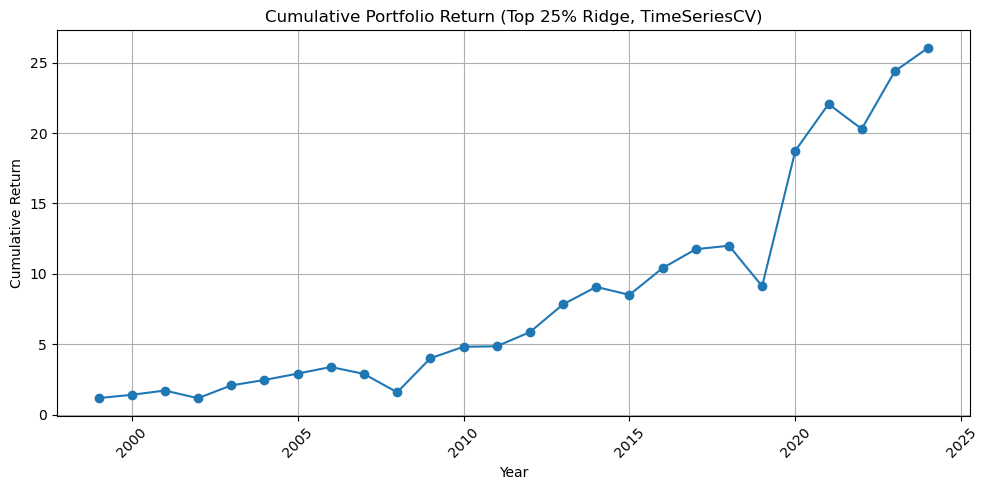

In [56]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Fijar semillas
np.random.seed(42)

# 1. Ordenar y preparar datos
normalized = df_norm.copy()
normalized['date'] = pd.to_datetime(normalized['date'])

# 2. Definir features válidas
features = [
    col for col in normalized.columns
    if col not in ['ticker', 'date', 'cap_category', 'target_12m_final']
    and not col.startswith('target')
]

X = normalized[features].replace([np.inf, -np.inf], np.nan)
y = normalized['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = normalized.loc[mask].copy()

# 3. Datos ya normalizados
X_scaled = X.values

# 4. Setup TimeSeriesSplit externo
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

# 5. Validación cruzada temporal
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # RidgeCV con validación interna también temporal
    ridge = RidgeCV(
        alphas=np.logspace(-6, 6, 13),
        scoring='neg_mean_squared_error',
        cv=TimeSeriesSplit(n_splits=3)
    )
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

        # Guardar para análisis global
    if fold == 0:
        all_y_true = y_test.copy()
        all_y_pred = pd.Series(y_pred, index=y_test.index)
    else:
        all_y_true = pd.concat([all_y_true, y_test])
        all_y_pred = pd.concat([all_y_pred, pd.Series(y_pred, index=y_test.index)])




    # DataFrame de test
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final']].copy()
    df_test['predicted_return'] = y_pred
    df_test['fold'] = fold + 1

    # Evaluación por año
    for year, group in df_test.groupby(df_test['date'].dt.year):
        # Top 25% predicho
        cutoff = group['predicted_return'].quantile(0.75)
        overperf = group[group['predicted_return'] > cutoff]

        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0

        # Matriz de confusión simulada
        group['y_true'] = (group['target_12m_final'] > group['target_12m_final'].quantile(0.75)).astype(int)
        group['y_pred'] = (group['predicted_return'] > cutoff).astype(int)

        try:
            report = classification_report(group['y_true'], group['y_pred'], output_dict=True, zero_division=0)
            precision = report['1']['precision']
            recall = report['1']['recall']
            f1 = report['1']['f1-score']
        except:
            precision, recall, f1 = np.nan, np.nan, np.nan

        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

# 6. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 7. Métricas anuales promedio por año (sobre folds)
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'f1_score': 'mean'
}).reset_index()

# 8. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

# 9. Mostrar resultados
print(annual_results)

# 10. Graficar retorno acumulado
plt.figure(figsize=(10, 5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Top 25% Ridge, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


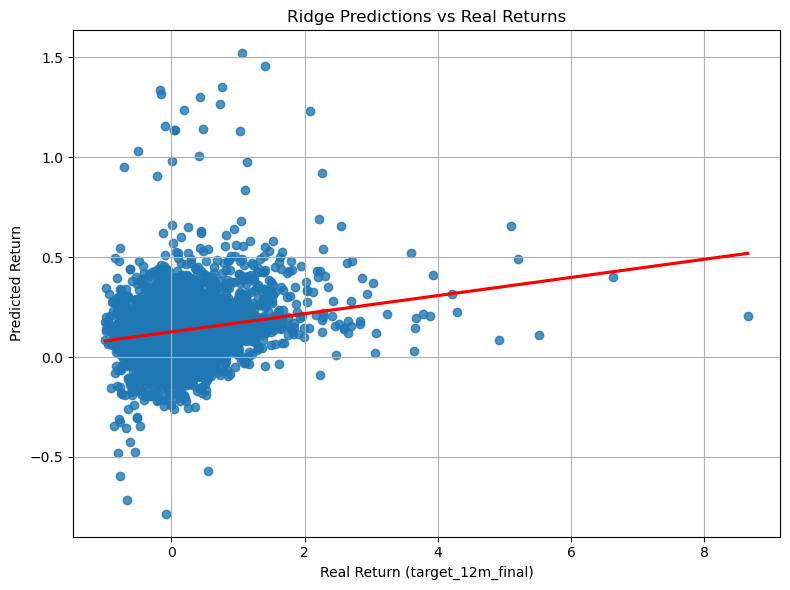

In [57]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

# DataFrame para graficar
df_plot = pd.DataFrame({
    'y_true': all_y_true,
    'y_pred': all_y_pred
})

# Scatter + línea de regresión
plt.figure(figsize=(8, 6))
sns.regplot(x='y_true', y='y_pred', data=df_plot, ci=None, line_kws={'color': 'red'})
plt.title("Ridge Predictions vs Real Returns")
plt.xlabel("Real Return (target_12m_final)")
plt.ylabel("Predicted Return")
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
r2 = np.corrcoef(df_plot['y_true'], df_plot['y_pred'])[0,1]**2
print(f"R² between predicted and actual returns: {r2:.3f}")


R² between predicted and actual returns: 0.036


In [23]:
data_base[data_base['ticker'] == 'AAPL']

,ticker,date,vol_1y,max_1y,min_1y,sma_1y,sma_2y,volatility_1y,revenue,eps,...,ret_6m_vol,sma_diff,dist_max_1y,dist_min_1y,vol_over_sma,cap_category,cap_Large Cap,cap_Mega Cap,cap_Mid Cap,cap_Small Cap
46,AAPL,1999-03-31,1.201984e+11,0.349,0.188,0.258909,0.240150,0.558725,5.941000e+09,0.021,...,-0.106015,0.018759,0.773639,1.436170,2.158001,Small Cap,False,False,False,True
47,AAPL,2000-03-31,1.322180e+11,1.083,0.255,0.578332,0.419063,0.643883,6.134000e+09,0.037,...,1.774945,0.159269,0.941828,4.000000,1.113345,Mid Cap,False,False,True,False
48,AAPL,2001-03-31,1.234202e+11,1.020,0.210,0.547171,0.561299,0.862587,7.983000e+09,0.043,...,-0.164759,-0.014128,0.325490,1.580952,1.576449,Small Cap,False,False,False,True
49,AAPL,2002-03-31,8.581031e+10,0.400,0.225,0.318391,0.436288,0.574943,5.363000e+09,-0.001,...,0.918173,-0.117897,0.890000,1.582222,1.805775,Small Cap,False,False,False,True
50,AAPL,2003-03-31,6.953108e+10,0.392,0.204,0.255427,0.286401,0.441550,5.742000e+09,0.003,...,-0.062333,-0.030974,0.540816,1.039216,1.728676,Small Cap,False,False,False,True
51,AAPL,2004-03-31,8.136332e+10,0.419,0.197,0.313746,0.284222,0.392336,6.207000e+09,0.003,...,0.778582,0.029524,0.968974,2.060914,1.250491,Small Cap,False,False,False,True
52,AAPL,2005-03-31,1.588330e+11,1.354,0.387,0.735446,0.524177,0.409954,8.279000e+09,0.013,...,2.808129,0.211269,0.924668,3.235142,0.557422,Mid Cap,False,False,True,False
53,AAPL,2006-03-31,1.843996e+11,2.572,1.026,1.627466,1.183226,0.399776,1.393100e+10,0.059,...,0.425440,0.444240,0.732893,1.837232,0.245643,Large Cap,True,False,False,False
54,AAPL,2007-03-31,2.095334e+11,2.918,1.523,2.261422,1.941931,0.361046,1.931500e+10,0.084,...,0.572140,0.319492,0.956820,1.833224,0.159654,Large Cap,True,False,False,False
55,AAPL,2008-03-31,2.731123e+11,6.006,2.712,4.224833,3.245838,0.427739,2.400600e+10,0.144,...,-0.151566,0.978994,0.718115,1.590339,0.101244,Mega Cap,False,True,False,False


c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.83915e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.20336e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.98471e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.12032e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users

Confusion Matrix:
 [[ 580  633 1433 1034]
 [ 144  172  389  241]
 [ 170  203  395  255]
 [ 687  786 1704 1774]]
Classification Report:
                       precision    recall  f1-score   support

      Negative (<0%)     0.3669    0.1576    0.2205      3680
 Underperform (0-5%)     0.0959    0.1818    0.1255       946
Near Perform (5-15%)     0.1007    0.3861    0.1598      1023
  Overperform (>15%)     0.5369    0.3583    0.4298      4951

            accuracy                         0.2756     10600
           macro avg     0.2751    0.2710    0.2339     10600
        weighted avg     0.3964    0.2756    0.3039     10600



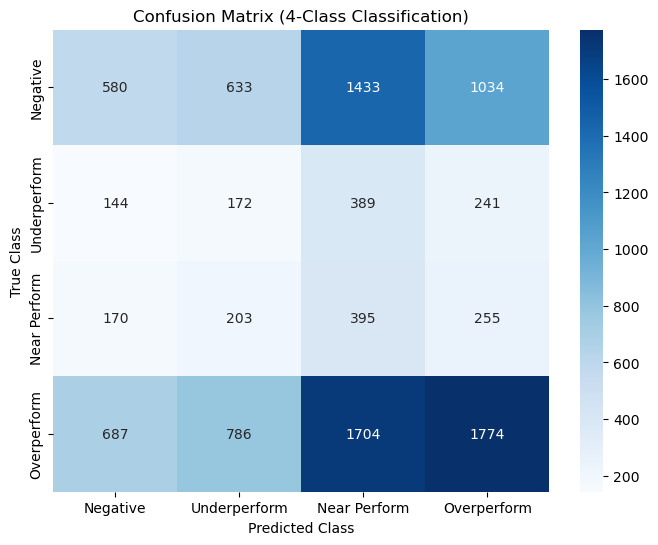

Sharpe Ratio: 0.5152
Sortino Ratio: 1.1858
Max Drawdown: -50.36%
Annualized Volatility: 0.3414
Calmar Ratio: 0.3493
Hit Rate: 77.27%


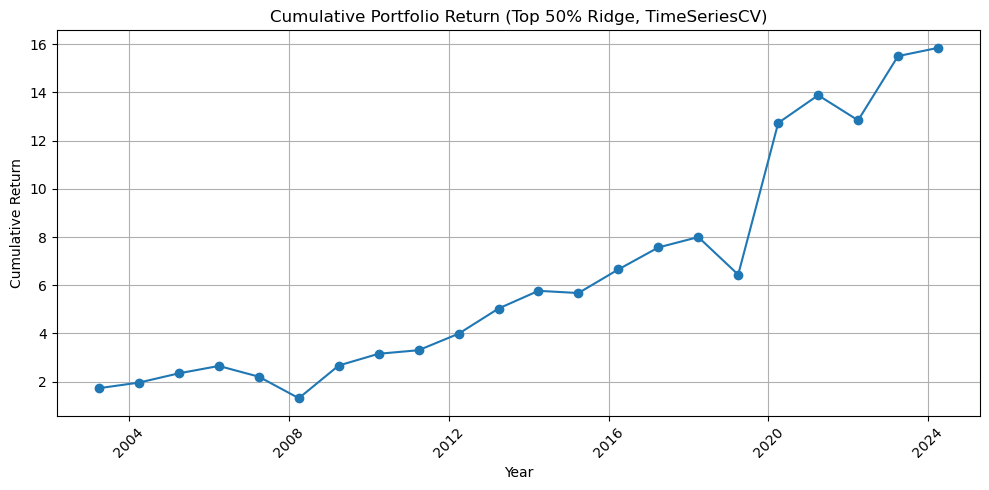

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, classification_report

# 0. Semillas para reproducibilidad
np.random.seed(42)

# 1. Ordenar datos
normalized = data_base.sort_values('date')

# 2. Definir features (no re-normalizar)
features = [
    col for col in normalized.columns
    if col not in ['ticker', 'date', 'cap_category', 'target_12m_final']
    and not col.startswith('target')
]

X = normalized[features].replace([np.inf, -np.inf], np.nan)
y = normalized['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = normalized.loc[mask].copy()

X_scaled = X.values  # ya normalizado

# 3. Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []
df_all_tests = []

# 4. Función para clasificación en 4 clases
def multiclass_label(ret):
    if ret < 0:
        return 0  # Negative
    elif ret < 0.06:
        return 1  # Underperform
    elif ret < 0.12:
        return 2  # Near Performance
    else:
        return 3  # Overperformance

# 5. Validación cruzada fold-by-fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), scoring='neg_mean_squared_error', cv=5)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final']].copy()
    df_test['predicted_return'] = y_pred
    df_test['fold'] = fold + 1
    df_all_tests.append(df_test)

    # Portafolio (top 50% predicho)
    for year, group in df_test.groupby('date'):
        overperf = group[group['predicted_return'] > group['predicted_return'].quantile(0.5)]
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 6. Resultados finales
df_all_tests = pd.concat(df_all_tests)
df_all_tests['true_class'] = df_all_tests['target_12m_final'].apply(multiclass_label)
df_all_tests['predicted_class'] = df_all_tests['predicted_return'].apply(multiclass_label)

results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

# 7. Métricas de clasificación
conf_matrix = confusion_matrix(df_all_tests['true_class'], df_all_tests['predicted_class'])
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(df_all_tests['true_class'], df_all_tests['predicted_class'], digits=4, target_names=[
    'Negative (<0%)', 'Underperform (0-5%)', 'Near Perform (5-15%)', 'Overperform (>15%)'
])
print("Classification Report:\n", report)

# 8. Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
    'Negative', 'Underperform', 'Near Perform', 'Overperform'
], yticklabels=[
    'Negative', 'Underperform', 'Near Perform', 'Overperform'
])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (4-Class Classification)')
plt.show()

# 9. Performance Metrics de la estrategia
returns = annual_results['portfolio_return']

# Sharpe Ratio (asumiendo 1 año)
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(1)
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# Sortino Ratio
downside_returns = returns[returns < 0]
sortino_ratio = returns.mean() / downside_returns.std() * np.sqrt(1)
print(f"Sortino Ratio: {sortino_ratio:.4f}")

# Max Drawdown
cumulative = (1 + returns).cumprod()
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown:.2%}")

# Volatilidad anualizada
annual_volatility = returns.std() * np.sqrt(1)
print(f"Annualized Volatility: {annual_volatility:.4f}")

# Calmar Ratio
calmar_ratio = returns.mean() / abs(max_drawdown)
print(f"Calmar Ratio: {calmar_ratio:.4f}")

# Hit Rate (años en que se gana dinero)
hit_rate = (returns > 0).sum() / len(returns)
print(f"Hit Rate: {hit_rate:.2%}")

# 10. Gráfico de retorno acumulado
plt.figure(figsize=(10, 5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Top 50% Ridge, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.64871e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.61839e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.57446e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.82761e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users

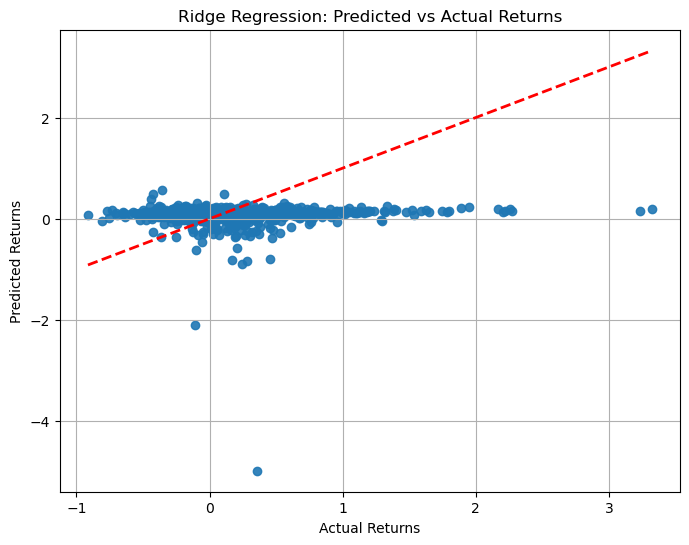

In [37]:
import matplotlib.pyplot as plt

# Assume you already have y_true and y_pred
# Example: after fitting Ridge
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# Now plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.9)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45° line

plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Ridge Regression: Predicted vs Actual Returns')
plt.grid()
plt.show()


c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.35924e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.87182e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.56006e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Ignacio\anaconda3\envs\thesis-ml\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.63899e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users

Confusion Matrix:
 [[ 555  621 1471 1033]
 [ 140  173  388  245]
 [ 164  200  404  255]
 [ 654  753 1798 1746]]
Classification Report:
                       precision    recall  f1-score   support

      Negative (<0%)     0.3668    0.1508    0.2137      3680
 Underperform (0-5%)     0.0990    0.1829    0.1285       946
Near Perform (5-15%)     0.0995    0.3949    0.1589      1023
  Overperform (>15%)     0.5325    0.3527    0.4243      4951

            accuracy                         0.2715     10600
           macro avg     0.2745    0.2703    0.2314     10600
        weighted avg     0.3945    0.2715    0.2992     10600



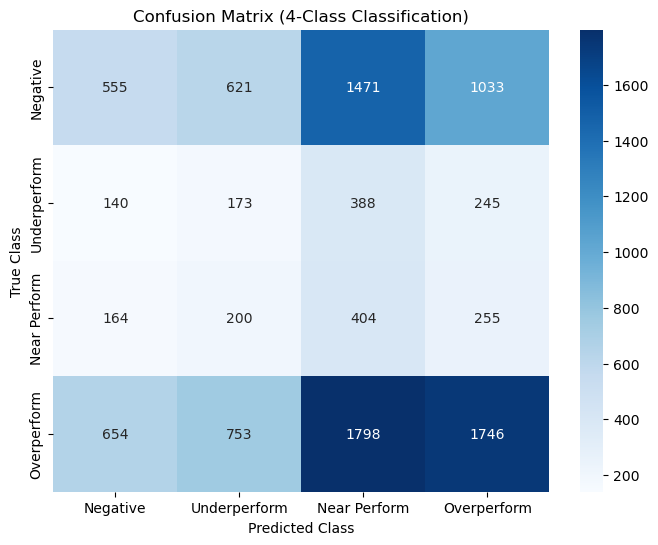

Sharpe Ratio: 0.5120
Sortino Ratio: 1.1894
Max Drawdown: -50.26%
Annualized Volatility: 0.3411
Calmar Ratio: 0.3475
Hit Rate: 77.27%


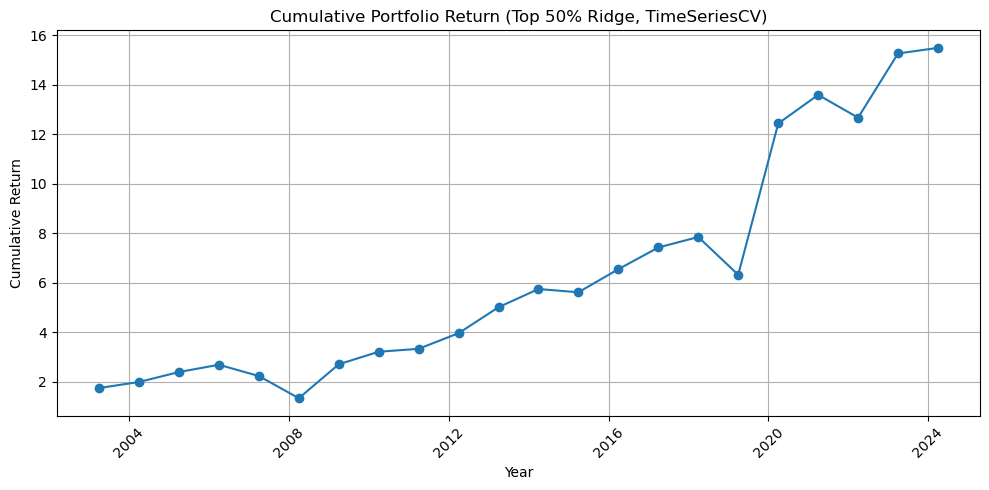

In [5]:
columns = ['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'roe',
       'evebitda', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'target_12m_final',
       'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit',
       'signed_log_marketcap', 'signed_log_equity', 'ebit_margin',
       'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps', 'ret_12m_vol',
       'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma',
       'cap_category', 'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap',
       'cap_Small Cap']

data = data_base[columns]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, classification_report

# 0. Semillas para reproducibilidad
np.random.seed(42)

# 1. Ordenar datos
normalized = data.sort_values('date')

# 2. Definir features (no re-normalizar)
features = [
    col for col in normalized.columns
    if col not in ['ticker', 'date', 'cap_category', 'sharpe', 'target_12m_final']
    and not col.startswith('target')
]

X = normalized[features].replace([np.inf, -np.inf], np.nan)
y = normalized['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = normalized.loc[mask].copy()

X_scaled = X.values  # ya normalizado

# 3. Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []
df_all_tests = []

# 4. Función para clasificación en 4 clases
def multiclass_label(ret):
    if ret < 0:
        return 0  # Negative
    elif ret < 0.06:
        return 1  # Underperform
    elif ret < 0.12:
        return 2  # Near Performance
    else:
        return 3  # Overperformance

# 5. Validación cruzada fold-by-fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), scoring='neg_mean_squared_error', cv=5)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final']].copy()
    df_test['predicted_return'] = y_pred
    df_test['fold'] = fold + 1
    df_all_tests.append(df_test)

    # Portafolio (top 50% predicho)
    for year, group in df_test.groupby('date'):
        overperf = group[group['predicted_return'] > group['predicted_return'].quantile(0.5)]
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 6. Resultados finales
df_all_tests = pd.concat(df_all_tests)
df_all_tests['true_class'] = df_all_tests['target_12m_final'].apply(multiclass_label)
df_all_tests['predicted_class'] = df_all_tests['predicted_return'].apply(multiclass_label)

results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

# 7. Métricas de clasificación
conf_matrix = confusion_matrix(df_all_tests['true_class'], df_all_tests['predicted_class'])
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(df_all_tests['true_class'], df_all_tests['predicted_class'], digits=4, target_names=[
    'Negative (<0%)', 'Underperform (0-5%)', 'Near Perform (5-15%)', 'Overperform (>15%)'
])
print("Classification Report:\n", report)

# 8. Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
    'Negative', 'Underperform', 'Near Perform', 'Overperform'
], yticklabels=[
    'Negative', 'Underperform', 'Near Perform', 'Overperform'
])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (4-Class Classification)')
plt.show()

# 9. Performance Metrics de la estrategia
returns = annual_results['portfolio_return']

# Sharpe Ratio (asumiendo 1 año)
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(1)
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# Sortino Ratio
downside_returns = returns[returns < 0]
sortino_ratio = returns.mean() / downside_returns.std() * np.sqrt(1)
print(f"Sortino Ratio: {sortino_ratio:.4f}")

# Max Drawdown
cumulative = (1 + returns).cumprod()
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown:.2%}")

# Volatilidad anualizada
annual_volatility = returns.std() * np.sqrt(1)
print(f"Annualized Volatility: {annual_volatility:.4f}")

# Calmar Ratio
calmar_ratio = returns.mean() / abs(max_drawdown)
print(f"Calmar Ratio: {calmar_ratio:.4f}")

# Hit Rate (años en que se gana dinero)
hit_rate = (returns > 0).sum() / len(returns)
print(f"Hit Rate: {hit_rate:.2%}")

# 10. Gráfico de retorno acumulado
plt.figure(figsize=(10, 5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Top 50% Ridge, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
